In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import numpy as np

from meshes import *

from NumericalSolutions import *
from DynamicSolutions import *

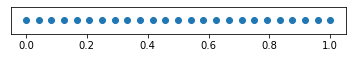

In [2]:
# Spatial resolution of mesh
N = 25

# Right limit of mesh
L = 1

# Generate 1D mesh
[nodes, elems, faces] = get_mesh_1D(N, [0,L], True);
elems = np.array(elems)[:-1,:]          # I believe there is one row too much in elems from get_mesh function

In [3]:
E=1
I=1
mu = 1

In [4]:
M0 = 0
ML = 0
QL = 0
a0 = 0
aL = 0
a = 0
b = 0

q = 1

two_sided_support = True 

if two_sided_support:
    boundary_conditions = {'M0': M0, 'ML': ML, 'a0': a0, 'aL': aL}
else:
    boundary_conditions = {'QL': QL, 'ML': ML, 'a': a, 'b': b}

In [5]:
"""
DynamicCase = Dynamic(E=E, I=I, N=N, L=L, 
                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":10},
                      #parameters = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":4},
                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":5, "q":0},
                      two_sided_support=True)
"""
DynamicCase = DynamicSolutionBothEnds(E=E, I=I, N=N, L=L, h=0.05,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":0},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":10}
                                     )
tsteps = 1000

h = 0.001

DynamicCase.Newmark.h = h
DynamicCase.Newmark.run(tsteps)

(array([ 0.00000000e+00,  7.84064809e-01,  3.25714074e-02,  7.77039445e-01,
         6.45641626e-02,  7.56398841e-01,  9.54250934e-02,  7.22833358e-01,
         1.24631288e-01,  6.77100247e-01,  1.51691823e-01,  6.19971884e-01,
         1.76148982e-01,  5.52295849e-01,  1.97584997e-01,  4.75160679e-01,
         2.15632617e-01,  3.89889030e-01,  2.29983551e-01,  2.97986079e-01,
         2.40396524e-01,  2.01175281e-01,  2.46705850e-01,  1.01306800e-01,
         2.48818858e-01, -2.65046023e-13,  2.46705850e-01, -1.01306800e-01,
         2.40396524e-01, -2.01175281e-01,  2.29983551e-01, -2.97986079e-01,
         2.15632617e-01, -3.89889030e-01,  1.97584997e-01, -4.75160679e-01,
         1.76148982e-01, -5.52295849e-01,  1.51691823e-01, -6.19971884e-01,
         1.24631288e-01, -6.77100247e-01,  9.54250934e-02, -7.22833358e-01,
         6.45641626e-02, -7.56398841e-01,  3.25714074e-02, -7.77039445e-01,
         0.00000000e+00, -7.84064809e-01,  8.22520196e+00, -8.22520196e+00]),
 array([ 0

In [6]:
Max_Values = []

results = DynamicCase.Newmark.results
w = results["w"]
wp = results["wp"]
wd = results["wd"]

u = results["u"]
up = results["up"]
upp = results["upp"]

Me = DynamicCase.Newmark.Me
Se = DynamicCase.Newmark.Se
rhs = DynamicCase.dynamic_object.RHS_ext

In [7]:
def Energy(u, up, M, S, Only_E1=False, Only_E2=False):
    
    up2 = up @ M
    
    wd2 = up2[:-2][::2]
    wd1 = up[:-2][::2]
    
    term1 = np.inner(wd2, wd1)
    
    u2 = u @ S
    w2 = u2[:-2][::2]
    w1 = u[:-2][::2]
    
    term2 = np.inner(w2, w1)

    if Only_E1:
        return term1
    
    elif Only_E2:
        return term2
    
    else:
        return term1 + term2
    
def ExternalEnergy(u, q):
    
    w = u[:-2][::2]
    q = q[:-2][::2]
    
    return 2*np.inner(w,q)

In [8]:
E1 = []
E2 = []
E = []

Ext = []


for i in range(1,np.shape(w)[0]):
    
    up2 = up[i] @ Me
    
    wd2 = up2[:-2][::2]
    wd1 = up[i][:-2][::2]
    
    E1.append(np.inner(wd2, wd1))
    
    u2 = u[i] @ Se
    
    w2 = u2[:-2][::2]
    w1 = u[i][:-2][::2]
    
    E2.append(np.inner(w2, w1))
    
    E.append(np.inner(w2, w1) + np.inner(wd2, wd1))
    
    Ext.append(ExternalEnergy(u[i], rhs))
    
    

In [9]:
E1 = []
E2 = []
E = []
Ext = []

for i in range(1,np.shape(w)[0]):
    
    
    E.append(Energy(u[i], up[i], Me, Se))
    E1.append(Energy(u[i], up[i], Me, Se, Only_E1=True))
    E2.append(Energy(u[i], up[i], Me, Se, Only_E2=True))
    Ext.append(ExternalEnergy(u[i], rhs))

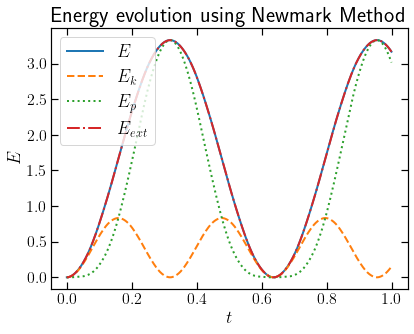

In [10]:
plt.style.use("standard.mplstyle")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E, "-", label=r"$E$")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E1, "--", label=r"$E_k$")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), E2, ":", label=r"$E_p$")
plt.plot(h*np.array([i for i in range(np.shape(E)[0])]), Ext, "-.", label=r"$E_{ext}$")
plt.legend()
plt.title("Energy evolution using Newmark Method")
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.legend( prop={"size": 18})
plt.savefig("./Report/Newmark_Energy_Evolution_Load.pdf")

In [11]:
Energies = {}

hs = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

tt = 0.5

for h in hs:
    Energies[h] = []
    
for h in hs:
    
    tsteps = int(tt / h)
    
    DynamicCase = DynamicSolutionBothEnds(E=1, I=1, N=N, L=L, h=h,
                                      initial_conditions = {"ML":ML, "M0":M0, "a0":a0, "aL":aL, "q":10},
                                      parameters = {"ML":ML, "M0":M0, "a0":0, "aL":0, "q":0}
                                     )
    DynamicCase.Newmark.h = h
    DynamicCase.Newmark.run(tsteps)
    
    results = DynamicCase.Newmark.results
    u = results["u"]
    up = results["up"]

    Me = DynamicCase.Newmark.Me
    Se = DynamicCase.Newmark.Se
    
    for i in range(1,np.shape(u)[0]):

        Energies[h].append(Energy(u[i], up[i], Me, Se))

        

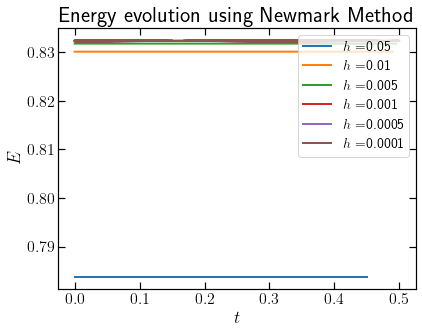

In [12]:
#hs = [0.0001, 0.0005, 0.001]

for h in hs:
    
    plt.plot(h*np.array([i for i in range(int(tt/h))]), Energies[h], label= r"$h=$"+ str(h))
    
plt.legend(loc = "upper right", prop={"size": 14})

plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.title("Energy evolution using Newmark Method")
plt.savefig("./Report/Newmark_Energy_Evolution.pdf")
plt.show()


In [13]:
Amplitudes = []

for h in hs:
    
    ampl = (np.max(Energies[h]) - np.mean(Energies[h]) ) / np.mean(Energies[h])
    
    Amplitudes.append(ampl)

In [14]:
print(Amplitudes)

[7.467517057468035e-09, 9.013204567416711e-07, 3.947276118651671e-06, 1.9856904729687832e-05, 3.999079079832268e-05, 0.00016500988067238133]


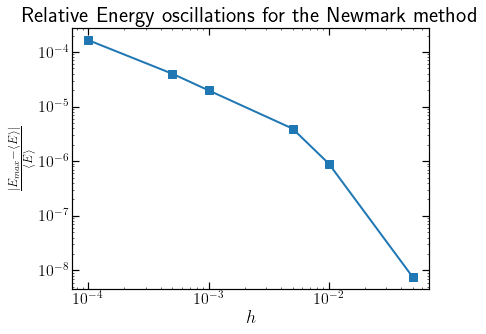

In [15]:
plt.style.use("standard.mplstyle")
plt.loglog(hs, Amplitudes, "-s")
plt.title("Relative Energy oscillations for the Newmark method")
plt.xlabel(r"$h$")
plt.ylabel(r"$\frac{|E_{max} - \langle E \rangle|}{ \langle E \rangle}$")
plt.savefig("./Report/EnergyOscillations.pdf")